In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline
import glob

$$Camera$$ $$Calibration$$

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/*.jpg')

for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = 'corners_found'+str(i)+'.jpg'
        cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return undist


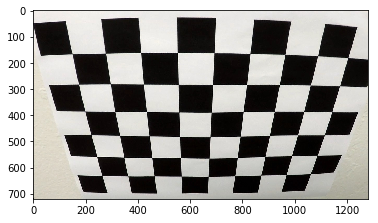

In [3]:
img = mpimg.imread('camera_cal/calibration2.jpg')
img_undist = cal_undistort(img, objpoints=objpoints, imgpoints=imgpoints)
plt.imshow(img)

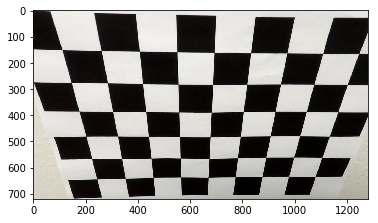

In [4]:
plt.imshow(img_undist)

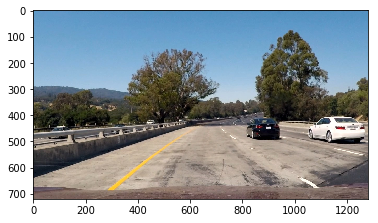

In [5]:
image = mpimg.imread('test_images/test1.jpg')
plt.imshow(image)

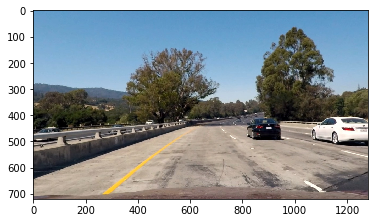

In [6]:
road_undist = cal_undistort(image, objpoints=objpoints, imgpoints=imgpoints)
plt.imshow(road_undist)

In [7]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = 7))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize = 7))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


In [8]:
def mag_thresh(img, sobel_kernel=7, mag_thresh=(0, 255)):

    # Apply the following steps to img
    # 1) Convert to grayscale
    im = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = np.absolute(cv2.Sobel(im, cv2.CV_64F, 1, 0, ksize = 7))
    sobely = np.absolute(cv2.Sobel(im, cv2.CV_64F, 0, 1, ksize = 7))
    # 3) Calculate the magnitude 

    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    #scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    # 5) Create a binary mask where mag thresholds are met
    #binary_output = np.zeros_like(scaled_sobel)

    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    #return binary_output
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


In [9]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):

    # Apply the following steps to img
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


In [10]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(hls[:,:,2])
    binary_output[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    #binary_output = np.copy(img) # placeholder line
    return binary_output

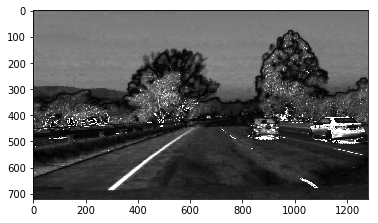

In [11]:
hls_conv = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
plt.imshow(hls_conv[:,:,2], cmap='gray')

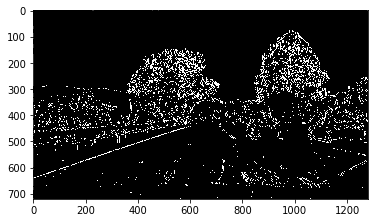

In [12]:
a = abs_sobel_thresh(image, 'x', 20, 50)
plt.imshow(a, cmap ='gray')

In [13]:
ksize = 7
gradx = abs_sobel_thresh(image, 'x', 50, 70)
grady = abs_sobel_thresh(image, 'y', 50, 80)    
mag_binary = mag_thresh(image, ksize, (50, 90))
dir_binary = dir_threshold(image, ksize, (0, 20))

In [14]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

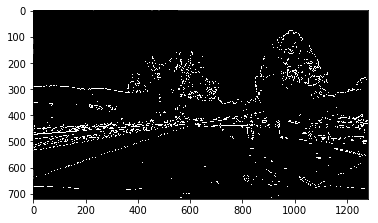

In [15]:
plt.imshow(combined, cmap ='gray')

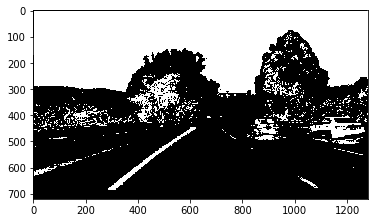

In [16]:
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]
thresh = (90, 255)
binary = np.zeros_like(S)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1
plt.imshow(binary
           , cmap ='gray')

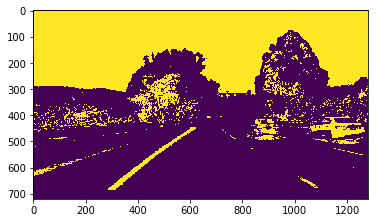

In [17]:
hls_binary = hls_select(image, thresh=(90, 255))
plt.imshow(hls_binary)


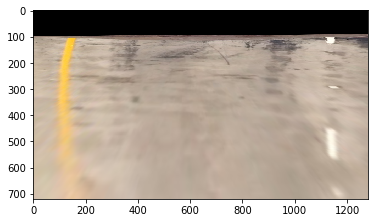

In [55]:
img_size = (road_undist.shape[1], road_undist.shape[0])
'''src = np.float32([[352, 621],
                  [947, 621],
                  [710, 465],
                  [572, 465]
                  ])
src = np.float32([[301, 675],
                  [1085, 675],
                  [734, 465],
                  [595, 465]
                  ])
'''
src = np.float32([[342, 645],
                  [1024, 638],
                  [748, 475],
                  [574, 475]
                  ])
offset = 135
dst = np.float32([[offset, offset],
                  [img_size[0]-offset, offset],
                  [img_size[0]-offset, img_size[1]-offset],
                  [offset, img_size[1]-offset]
                 ])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
# Warp the image using OpenCV warpPerspective()
binary_warped = cv2.warpPerspective(road_undist, M, img_size)

rev_trans = cv2.warpPerspective(road_undist, Minv, img_size)
plt.imshow(binary_warped)

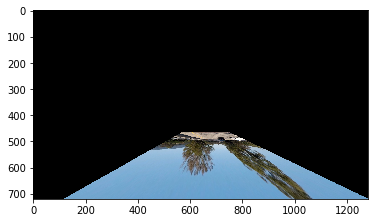

In [56]:
plt.imshow(rev_trans)

In [57]:
def pipeline(img, s_thresh=(100, 250), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return color_binary, combined_binary

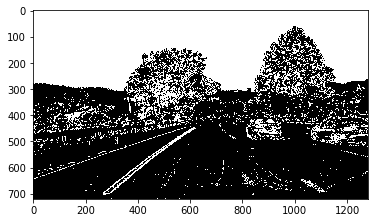

In [58]:
plt.imshow(pipeline(road_undist)[1], cmap ='gray')

(720, 1280)


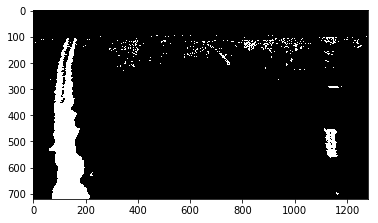

In [59]:
bin_img = pipeline(binary_warped)[1]
plt.imshow(bin_img, cmap ='gray')
print(bin_img.shape)
binary_warped = bin_img

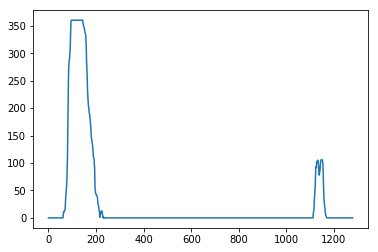

In [198]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [199]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped,binary_warped,binary_warped))*255
#print(out_img.shape)
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2) 
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint


In [200]:
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

In [201]:
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 50
# Set minimum number of pixels found to recenter window
minpix = 100
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []


# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    try:
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
    except:
        print(out_img.shape,win_xleft_low, win_y_low, win_xleft_high, win_y_high)
    
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))


In [202]:

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

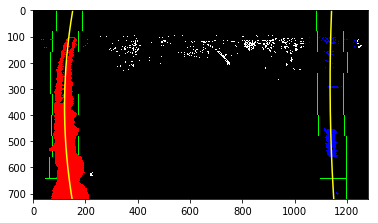

In [205]:
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [206]:
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
left_fit[1]*nonzeroy + left_fit[2] + margin))) 

right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

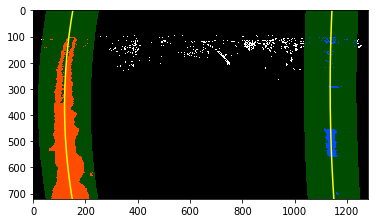

In [208]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [209]:
#ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-5 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)

leftx = np.array([130 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([1140+ (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])
leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y




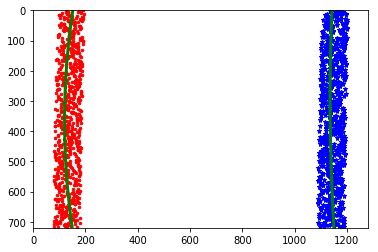

In [213]:
# Fit a second order polynomial to pixel positions in each fake lane line
#'''
'''
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
'''

# Plot up the fake data
mark_size = 5
plt.plot(leftx, ploty, '.', color='red', markersize=mark_size)
plt.plot(rightx, ploty, '*', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [214]:
y_eval = np.median(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

2130.81424412 6381.76469255


In [215]:
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/1280 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')


43382.831751 m 8001.44910694 m


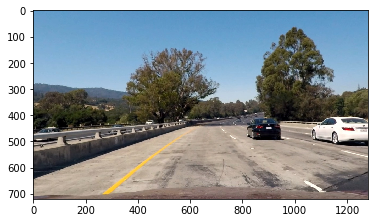

In [216]:
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.hstack((pts_left, pts_right))
plt.imshow(road_undist)

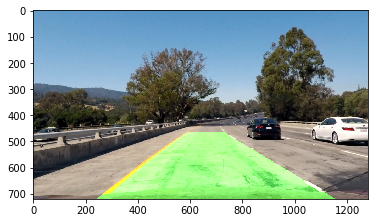

In [217]:

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (binary_warped.shape[1], binary_warped.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(road_undist, 1, newwarp, 0.5, 0)
plt.imshow(result)

In [191]:
vidcap = cv2.VideoCapture('project_video.mp4')
success,image = vidcap.read()
count = 0
i = 0
success = True
while success:
    success,image = vidcap.read()
    if (count == 7):
        count = 0
        cv2.imwrite("vid_img/%d.jpg" %i, image)
        i += 1
   
    count += 1

In [219]:
def processing(img, objpoints, imgpoints, M, i):
    road_undist = cal_undistort(img, objpoints=objpoints, imgpoints=imgpoints)
    binary_warped = cv2.warpPerspective(road_undist, M, img_size)
    binary_warped = pipeline(binary_warped)[1]
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped,binary_warped,binary_warped))*255
    #print(out_img.shape)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []


    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    #ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-5 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([130 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                  for y in ploty])
    rightx = np.array([1140+ (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fit = np.polyfit(ploty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(road_undist, 1, newwarp, 0.5, 0)
    plt.imsave('proc_vid/%d.jpg' %i, result)

In [220]:
vid_imgs = glob.glob('vid_img/*.jpg')
files = []
for i in range(len(vid_imgs)-1):
    files.append('vid_img/'+str(i)+'.jpg')

In [ ]:
for i, fname in enumerate(files):
    img = mpimg.imread(fname)
    processing(img, objpoints, imgpoints, M, i)
    #cv2.imwrite('proc_vid/'+str(i)+'.jpg', image)

In [ ]:
%run vid